# End to End multiclass dog breed Classification

This notebook builds an end to end multiclass image classifier using tensorflow 2.0 and tensorflow hub.

## 1. Problem

Identifying the breed of a dog given an image of a dog.

## 2. Data

Download from kaggle dog breed identification competition.

## 3. Evaluation

The Evaluation is a file with prediction probabilities for each dog breed of each test image.

## 4. Features

Some information about the data :

* We're dealing with images (unstuctured data) so it's probably best we use deep learning / transfer learning.
* There are 120 breeds of dogs (this means there are 120 different classes).
* There are 10000+ images in the training set.( these images have labels )
* There are 10000+ images in the test set. ( these images have no labels )

### Getting our workspace ready

* Import Tensorflow 2.x
* Import Tensorflow Hub
* Make sure we're using GPU

In [1]:
import tensorflow as tf
import keras
print("TF Version :",tf.__version__)

TF Version : 2.2.0


Using TensorFlow backend.


In [2]:
import tensorflow_hub as hub
print("TF Hub Version",hub.__version__)

TF Hub Version 0.8.0


In [3]:
config=tf.compat.v1.ConfigProto(log_device_placement=True)
config.gpu_options.allow_growth=True
session=tf.compat.v1.InteractiveSession(config=config)


Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce MX250, pci bus id: 0000:02:00.0, compute capability: 6.1
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device



In [4]:
# Check for GPU availability
print("GPU","available (YESSS!!!!!)" if tf.config.list_physical_devices("GPU") else "not available:")

GPU available (YESSS!!!!!)


In [5]:
print("TPU","available (YESSS!!!!!)" if tf.config.list_physical_devices("TPU") else "not available:")

TPU not available:


## Getting our Data ready (turning into tensors)

With all machine learning models,our data has to be in numerical format. So that's what we'll be doing first. Turning our images into tensors (numerical representation)

In [6]:
import pandas as pd
label_csv=pd.read_csv("dog-breed-identification/labels.csv")
print(label_csv.describe())
print(label_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     b3211bbd40fb727bdb50fdad2b6c2638  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [7]:
label_csv.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

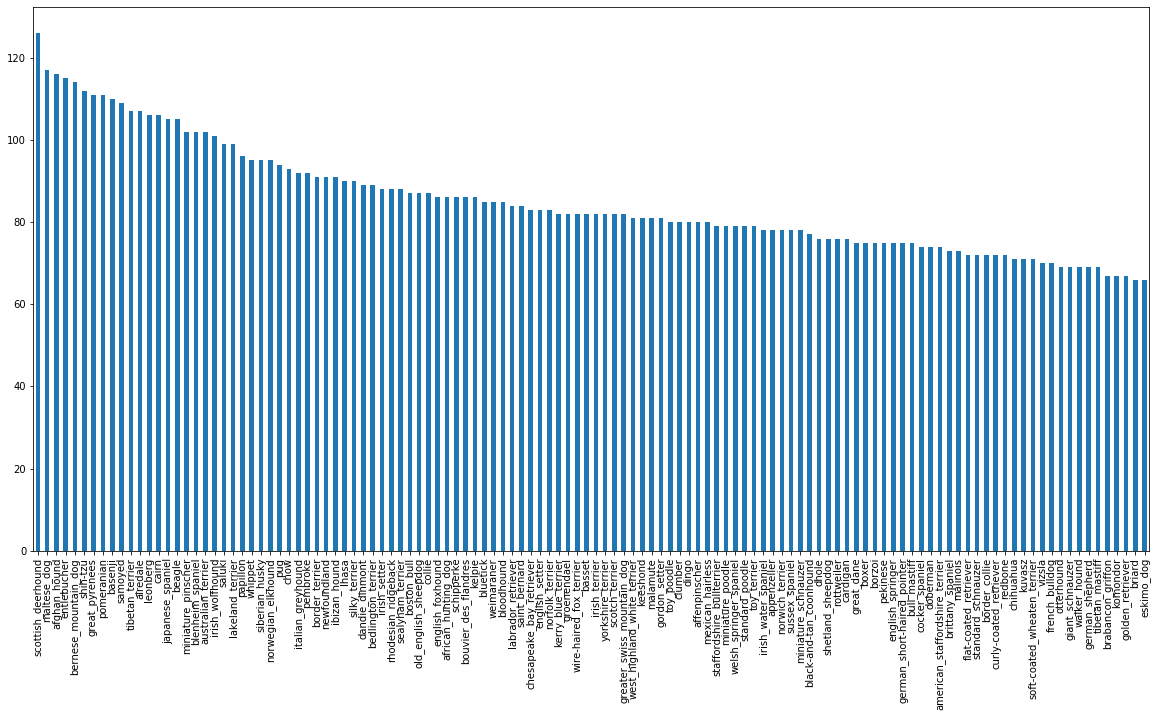

In [8]:
# How many images are there of each breed?
label_csv["breed"].value_counts().plot.bar(figsize=(20,10));

In [9]:
label_csv["breed"].value_counts().median()

82.0

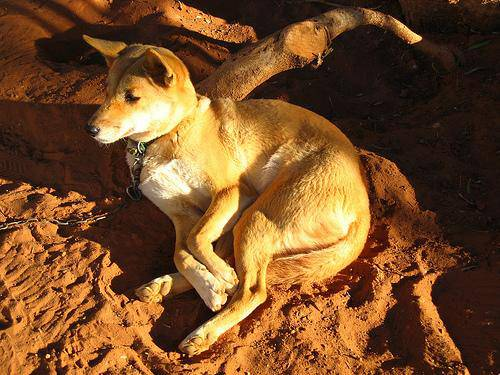

In [10]:
from IPython.display import Image
Image("dog-breed-identification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg")

<img src="dog-breed-identification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg">

### Getting images and their labels

Let's get a list of all of our image file pathnames

In [11]:
# create pathnames from image ID's
filenames=["dog-breed-identification/train/"+fname+".jpg" for fname in label_csv["id"]]

filenames[:10]

['dog-breed-identification/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'dog-breed-identification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'dog-breed-identification/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'dog-breed-identification/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'dog-breed-identification/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'dog-breed-identification/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'dog-breed-identification/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'dog-breed-identification/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'dog-breed-identification/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'dog-breed-identification/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [12]:
import os
if len(os.listdir("dog-breed-identification/train/"))==len(filenames):
    print("Filenames match actual amount  of files")
else:
    print("Filenames don't match actual amount  of files")
    

Filenames match actual amount  of files


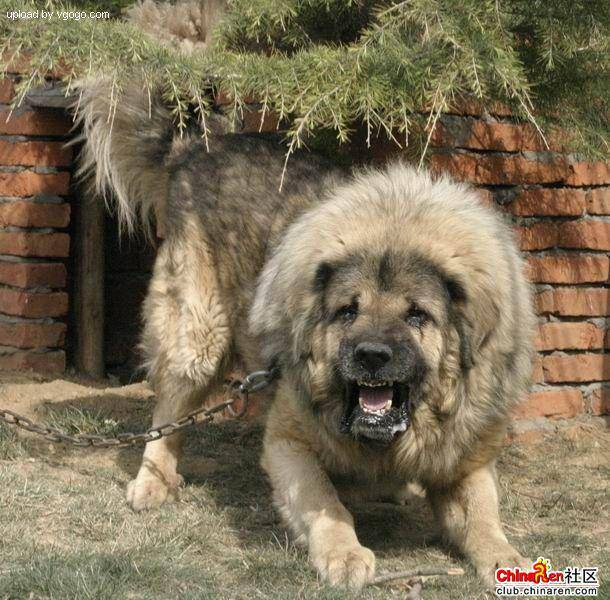

In [13]:
# One more check
Image(filenames[9000])

In [14]:
label_csv["breed"][9000]

'tibetan_mastiff'

Since we've got our training image filepaths in a list,let's prepare our labels.

In [15]:
import numpy as np
labels=label_csv["breed"].to_numpy()
# labels=np.array(labels) # Does same thing as above
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [16]:
len(labels)

10222

In [17]:
# Check if number of labels is equal to number of filenames
if len(labels)==len(filenames):
    print("Number of labels matches number of filenames")
else:
    print("Number of labels doesn't matches the number of filenames")



Number of labels matches number of filenames


In [18]:
# Find the unique label values 
unique_breeds=np.unique(labels)
len(unique_breeds)

120

In [19]:
# turn a single label into  an array of booleans
print(labels[0])
labels[0]==unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [20]:
# Turn every label into a boolean array

boolean_labels=[label==unique_breeds for label in labels]
boolean_labels

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [21]:
len(boolean_labels)

10222

In [22]:
# Example: Turning boolean array into integers
print(labels[0]) # original label
print(np.where(unique_breeds==labels[0])) # index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # there will be a 1 where the sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


## Creating our own validatoin set

Since the dataset from Kaggle doesn't come with a validation set, we're going to create our own.

In [23]:
# Setup X and Y variables
X=filenames
Y=boolean_labels

We're going to start off experimenting with ~1000 images and increase as needed.

In [24]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 

In [25]:
# Let's split our data into train and validation sets
from sklearn.model_selection import train_test_split
X_train,X_val,Y_train,Y_val=train_test_split(X[:NUM_IMAGES],Y[:NUM_IMAGES],test_size=0.2,random_state=42)
len(X_train),len(X_val),len(Y_train),len(Y_val)

(800, 200, 800, 200)

In [26]:
# Let's have a gaze at the training data
X_train[:5],Y_train[:5]

(['dog-breed-identification/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'dog-breed-identification/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  'dog-breed-identification/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  'dog-breed-identification/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  'dog-breed-identification/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, 

## Preprocessing Images (turning images into tensors)

To preprocess our images into Tensors we're going to write a function which does a few things:
1. Take  an image filepath as input
2. Use TensorFlow to read the file and save it to a variable ,`image`
3. Turn our `image` (a jpg) into Tensors
4. Normalize our `image` (convert color channel values from 0-255 to 0-1)
5. Resize the `image` to be a shape of (224,224)
6. Return the modified `image`

In [27]:
# convert an image to numpy array
from matplotlib.pyplot import imread
image=imread(filenames[42])
image.shape

(257, 350, 3)

In [28]:
image.max(),image.min()

(255, 0)

In [29]:
image[:2]

array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)

In [30]:
# Turn image into tensors
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)>

### Function to preprocess image

In [31]:
# Define image size
IMG_SIZE=224

def preprocess_image(image_path,img_size=IMG_SIZE):
    """
    Takes an image file path and turns the image into a Tensors.
    """
    # Read in an image file
    image = tf.io.read_file(image_path)
    # Turn the jpg image into numerical Tensors with 3 colour channels (Red,Green,Blue)
    image=tf.image.decode_jpeg(image,channels=3)
    # Convert the colour channel values from 0-255 to 0-1 values
    image=tf.image.convert_image_dtype(image,tf.float32)
    # Resize the image to our desired value (224,224)
    image=tf.image.resize(image,size=(IMG_SIZE,IMG_SIZE))
    
    return image

## Turning our data into batches

Why turn our data into batches?
Let's say you're trying to process 10,000+ images in one go... they all might not fit into memory.
That's why we do about 32 (this is the batch size) images at a time (you can manually adjust the batch size if need be). 

In order to use Tensorflow effectively, we need our data in the form of Tensor tuples which look like this: `(image,label)`

In [32]:
# Create a function to return a tuple (image,label)
def get_image_label(image_path,label):
    """
    Takes an image file path name and the associated label, proesses the image and returns a tuple of (image,label)
    """
    image=preprocess_image(image_path)
    return image,label

In [33]:
# Demo of the above 
(preprocess_image(X[42]),tf.constant(Y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

Now we've got a way to turn our data into tuples of Tensors in the form : `(image,label)`,let's make a function to turn all of our data(`X`&`Y`) into batches.

In [34]:
# Define the batch size , 32 is a good start
BATCH_SIZE=16

# Create a function to turn data into batches 
def create_data_batches(X,Y=None,batch_size=BATCH_SIZE,valid_data=False,test_data=False):
    """
    Creates batches of data out of image (X) and label (Y) pairs.
    Shuffles the data if it's training data but doesn't shuffle if it's validation data.
    Also accepts test data as input (no labels).
    """
    # If the data is a test dataset,we probably don't have labels
    if test_data:
        print("Creating test data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # Only filepaths (no labels)
        data_batch=data.map(preprocess_image).batch(BATCH_SIZE)
        return data_batch
    
    # if the data is a valid dataset ,we don't need to shuffle it 
    elif valid_data:
        print("Creating valid data batches....")
        data=tf.data.Dataset.from_tensor_slices((tf.constant(X),# Filepaths
                                                tf.constant(Y)))# labels
        data_batch=data.map(get_image_label).batch(BATCH_SIZE)
        return data_batch
    else:
        print("Creating training data batches....")
        # Turn filepaths and labels into Tensors
        data=tf.data.Dataset.from_tensor_slices((tf.constant(X),# Filepaths
                                                tf.constant(Y)))# labels
        # Shuffeling pathnames and labels before mapping image processor function is much faster than shuffling images.
        data=data.shuffle(buffer_size=len(X))
        
        # Creates (image,label) tuples (this also turn the image path into a preprocessessed image)
        data_batch=data.map(get_image_label).batch(BATCH_SIZE)
        return data_batch
    

In [35]:
# Creating training and validation data batches
train_data=create_data_batches(X_train,Y_train)
val_data=create_data_batches(X_val,Y_val,valid_data=True)

Creating training data batches....
Creating valid data batches....


In [36]:
# Check out the different attributes of our data batches
train_data.element_spec,val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualizing Data Batches

Our data is now in batches,however, these can be a little hard to understand/comprehend,let's visualize them!

In [37]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch
def show_15_images(images,labels):
    """
    Display a plot of 15 images and their labels from a data batch
    """
    # Setup the figure
    plt.figure(figsize=(10,10))
    
    # loop through 15 (for displaying 15 images)
    for i in range(15):
        # Create subplots (5 rows,3 columns)
        ax=plt.subplot(5,3,i+1)
        # Display an image
        plt.imshow(images[i])
        # Add the image label as the title
        plt.title(unique_breeds[labels[i].argmax()])
        # Turn off grid lines
        plt.axis("off")
        

In [38]:
train_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [39]:
train_images,train_labels=next(train_data.as_numpy_iterator())

In [40]:
train_images,train_labels

(array([[[[0.30430102, 0.36924303, 0.21572365],
          [0.31549022, 0.38354796, 0.1797577 ],
          [0.30408782, 0.3452532 , 0.1950618 ],
          ...,
          [0.470972  , 0.48865306, 0.3641666 ],
          [0.47322187, 0.4967345 , 0.3364588 ],
          [0.48918954, 0.51845294, 0.3202111 ]],
 
         [[0.29512745, 0.32011726, 0.16732632],
          [0.31053406, 0.32970423, 0.13374382],
          [0.34635708, 0.34474292, 0.2022359 ],
          ...,
          [0.4988949 , 0.51455   , 0.29707915],
          [0.48804036, 0.50769854, 0.2538857 ],
          [0.5012343 , 0.52688134, 0.24534288]],
 
         [[0.32222047, 0.315908  , 0.14767563],
          [0.37123066, 0.36718133, 0.15504545],
          [0.3524539 , 0.32343015, 0.18014994],
          ...,
          [0.50538003, 0.4960579 , 0.3183584 ],
          [0.510263  , 0.50481296, 0.29888475],
          [0.5517033 , 0.5515556 , 0.31968907]],
 
         ...,
 
         [[0.386366  , 0.47327074, 0.45769745],
          [0.39706

In [41]:
len(train_images),len(train_labels)

(16, 16)

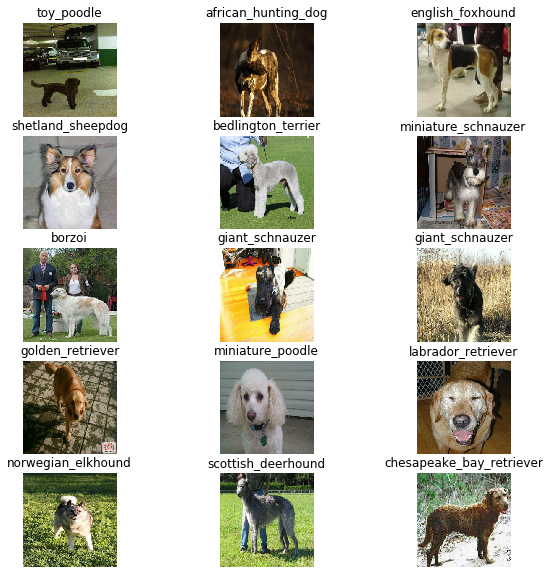

In [42]:
# now let's visualize the data in training batch
show_15_images(train_images,train_labels)

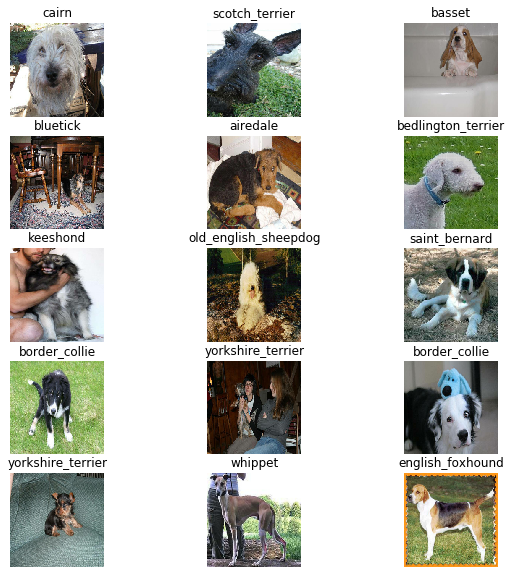

In [43]:
# Let's visualize the validation set
val_images,val_labels=next(val_data.as_numpy_iterator())
show_15_images(val_images,val_labels)

## Building a model

Before we build a model ,there are a few things we need to definr:
    1. The input shape (our images shape, in the form of Tensors) to our model.
    2. The output shape(image labels,in the form of Tensors) of our model.
    3. The URL of the model we want to use from tensorflow hub.

In [44]:
# Setup input shape to the model
INPUT_SHAPE=[None,IMG_SIZE,IMG_SIZE,3] # Batch,height,width,colour channels

# Setup output shape of our model
OUTPUT_SHAPE=len(unique_breeds)

# Setup model URL from TensorFlow Hub
MODEL_URL="Downloads/imagenet_mobilenet_v2_130_224_classification_4"

Now we've got our inputs,outputs and model ready to go.
Let's put them together into a Keras deep learning model!

Knowing this, let's create a function which:
   * Takes the input shape,output shape and the model we've chosen as parameters.
   * Defines the layers in a keras model in sequential fashion (do this first,then this, then that)
   * Compiles the model (says it should be evaluated and improved)
   * Builds the model (tells the model the input shape it'll be getting)
   * Returns the model

In [45]:
# Create a function which builds a Keras model

def create_model(input_shape=INPUT_SHAPE,output_shape=OUTPUT_SHAPE,model_url=MODEL_URL):
    print("Building model with:",MODEL_URL)
    
    # Setup the model layers
    model=tf.keras.Sequential([
        hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
        tf.keras.layers.Dense(units=OUTPUT_SHAPE,activation="softmax") # Layer 2 (output layer)
    ])
    
    # Compile the model
    model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
    )
    
    # Build the model
    model.build(INPUT_SHAPE)
    
    return model

In [46]:
model=create_model()
model.summary()

Building model with: Downloads/imagenet_mobilenet_v2_130_224_classification_4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  5432713   
_________________________________________________________________
dense (Dense)                multiple                  120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


## Creating Callbacks

Callbacks are helper functions a model can use during trainig to do such things as save its progress,check its progress or stop trainig early if a model stops improving.

We'll create two callbacks,one for TensorBoard which helps track our models progress and another for early stopping which prevents our model from training for too long.

### TensorBoard Callback

To setup a TensorBoard callback, we need to do 3 things :

1. Load the TensorBoard extension.
2. Create a TensorBoard callback  which is able to save logs to a directory and pass it to our model's `fit()` function.
3. Visualize our models training logs with the `%tensorboard` magic function (we'll do this after model training).

In [46]:
# Load Tensorboard notebook extension
%load_ext tensorboard

In [47]:
import datetime
# Create a function to build a Tensorboar callback
def create_tensorboard_callback():
    # Create a log directory for storing tensorboard logs
    logdir=os.path.join("dog-breed-identification/Logs",
                       # Make it so the logs get tracked whenever we run an experiment
                       datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    return tf.keras.callbacks.TensorBoard(logdir)

### Early stopping callback

Early stopping helps stop our model from overfitting by stopping training if a certain evaluation metric stops improving.

In [48]:
# create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=3)

## Training a model (on subset of data)

Our first model is only going to train on 1000 images ,to make sure everything is working.

In [49]:
NUM_EPOCHS=100 

In [50]:
print("GPU","Available" if tf.config.list_physical_devices("GPU") else "not available")

GPU Available


Let's create a function which trains a model

* Create a model using `create_model()`
* Setup a tensorboard callback using `create_tensorboard_callback()`
* Call the `fit()` on our model passing it the training data,validation data,number of epochs to train for(`NUM_EPOCHS`) and the callback we'd like to use.
* Return the model.

In [51]:
# Build a function to train and return a trained model

def train_model():
    """
    Trains a given model and returns the trained version.
    """
    # Create a model
    model=create_model()
    
    # Create new TensorBoard session everytime we train a model
    tensorboard =create_tensorboard_callback()
    
    # Fit the model to the data passing it the callbacks we created
    model.fit(x=train_data,
              epochs=NUM_EPOCHS,
              validation_data=val_data,
              validation_freq=1,
              callbacks=[tensorboard,early_stopping])
    # return the model
    return model

In [53]:
# Fit our model to the data
model=train_model()

Building model with: Downloads/imagenet_mobilenet_v2_130_224_classification_4
Epoch 1/100
50/50 [==============================] - 16s 321ms/step - loss: 4.1649 - accuracy: 0.1900 - val_loss: 2.8655 - val_accuracy: 0.3700
Epoch 2/100
50/50 [==============================] - 8s 153ms/step - loss: 1.0217 - accuracy: 0.8225 - val_loss: 1.8216 - val_accuracy: 0.5750
Epoch 3/100
50/50 [==============================] - 7s 149ms/step - loss: 0.2994 - accuracy: 0.9712 - val_loss: 1.5457 - val_accuracy: 0.6200
Epoch 4/100
50/50 [==============================] - 8s 154ms/step - loss: 0.1412 - accuracy: 0.9962 - val_loss: 1.4622 - val_accuracy: 0.6350
Epoch 5/100
50/50 [==============================] - 8s 155ms/step - loss: 0.0833 - accuracy: 0.9987 - val_loss: 1.4143 - val_accuracy: 0.6350
Epoch 6/100
50/50 [==============================] - 8s 154ms/step - loss: 0.0591 - accuracy: 1.0000 - val_loss: 1.3887 - val_accuracy: 0.6450
Epoch 7/100
50/50 [==============================] - 8s 155ms/s

**Question**:It looks our model is overfitting because it's performing far better on the training dataset than the validation dataset , what are some ways to prevent model overfitting in deep learning neural networks?


**Note**: Overfitting to begin with is a good thing!! It means our model is learning!!!!

## Checking the TensorBoard logs

The tensorboard magic function (`%tensorboard`) wil access the logs directory we created earlier and visualize its contents

In [54]:
%tensorboard --logdir dog-breed-identification/Logs

## Making and evaluating predictions using a trained model

In [55]:
# make predictions on the validation data (not used to train on)
predictions=model.predict(val_data,verbose=1)
predictions

13/13 [==============================] - 1s 104ms/step


array([[2.83953222e-03, 1.81070136e-05, 2.31277605e-04, ...,
        7.77962705e-05, 7.80293249e-06, 1.78693357e-04],
       [1.34813064e-03, 1.90211300e-04, 2.86622196e-02, ...,
        3.33598262e-04, 1.58879592e-03, 1.13400136e-04],
       [6.00542853e-06, 7.83317955e-05, 1.17809184e-04, ...,
        8.07685428e-05, 4.86405188e-05, 1.03070086e-03],
       ...,
       [5.25829682e-06, 1.38716805e-05, 6.26036490e-05, ...,
        5.46407819e-06, 5.72508434e-05, 5.46654883e-06],
       [3.81437247e-03, 8.25824682e-05, 1.28447486e-04, ...,
        7.55918081e-05, 1.40990796e-05, 1.02724191e-02],
       [6.77033560e-04, 2.84515318e-05, 1.25381732e-04, ...,
        1.33939309e-03, 1.14277587e-04, 2.99121293e-05]], dtype=float32)

In [56]:
predictions.shape

(200, 120)

In [57]:
# First prediction
index=42
print(predictions[index])
print(f"Max value (probability of prediction): {np.max(predictions[index])}")
print(f"Sum : {np.sum(predictions[index])}")
print(f"Max index: {np.argmax(predictions[index])}")
print(f"Predicted label: {unique_breeds[np.argmax(predictions[index])]}")

[8.60428700e-05 3.03890592e-05 2.08199308e-05 2.71557874e-05
 9.86377243e-04 4.58062350e-05 4.28304375e-05 4.19016258e-04
 1.22520849e-02 1.53175537e-02 1.07060578e-05 4.84488965e-07
 9.24665655e-05 1.26904412e-03 2.28181118e-04 5.76192397e-04
 1.45859076e-05 1.23030171e-04 8.04547963e-05 2.27805634e-04
 1.72444197e-05 6.95393363e-04 7.22113691e-05 7.72605017e-06
 1.38849928e-03 4.34921058e-05 9.57101838e-06 3.47764944e-05
 6.76200580e-05 2.03509680e-05 6.00010389e-06 1.24452388e-04
 1.91657200e-05 1.57854211e-05 1.47070086e-05 2.14426345e-05
 2.11389452e-05 5.99856830e-05 2.12107152e-05 1.35998219e-01
 6.91677851e-05 4.30765249e-06 1.25643564e-03 2.46577343e-07
 7.74779910e-05 1.45286676e-05 3.74173251e-04 3.93877563e-04
 8.11890732e-06 8.48168129e-05 6.15418103e-05 6.49262001e-05
 1.84824676e-05 1.18555571e-03 3.99543933e-05 2.31880142e-04
 1.81486976e-05 3.54284966e-05 8.03505463e-06 9.19794456e-06
 1.07817259e-05 2.12763887e-04 1.06267396e-06 5.69173881e-06
 1.87234073e-05 5.108734

Having the above functionality is great but we want to be able to do it at scale.

And it would be even better if we could see the image the prediction is being made on!

**Note** : Prediction probabilities are also known as confidence levels.

In [82]:
# Turn prediction probabilities into respective labels (easier to understand)
def get_pred_label(prediction_probabilities):
    """
    Turns an array of prediction probabilities into a label.
    """
    return unique_breeds[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of prediction probabilities
pred_label=get_pred_label(predictions[120])
pred_label


NameError: name 'predictions' is not defined

In [59]:
unique_breeds[81]

'norwich_terrier'

Now since our validation data is in a batch dataset,
we'll have to unbatchify it to make predictions on the validation images and then compare those predictions to the validation label (truth labels)

In [60]:
# Create a function to unbatch a batch dataset
def unbatchify(data):
    """
    Takes a batched dataset of (image,label) tensors and returns seperate arrays
    """
    images=[]
    labels=[]
    # Loop through unbatched data
    for image,label in data.unbatch().as_numpy_iterator():
        images.append(image)
        labels.append(unique_breeds[np.argmax(label)])
    return images,labels

# Unbatchify the validation data
val_images,val_labels=unbatchify(val_data)
val_images,val_labels

([array([[[0.29599646, 0.43284872, 0.3056691 ],
          [0.26635826, 0.32996926, 0.22846507],
          [0.31428418, 0.27701408, 0.22934894],
          ...,
          [0.77614343, 0.82320225, 0.8101595 ],
          [0.81291157, 0.8285351 , 0.8406944 ],
          [0.8209297 , 0.8263737 , 0.8423668 ]],
  
         [[0.2344871 , 0.31603682, 0.19543913],
          [0.3414841 , 0.36560842, 0.27241898],
          [0.45016077, 0.40117094, 0.33964607],
          ...,
          [0.7663987 , 0.8134138 , 0.81350833],
          [0.7304248 , 0.75012016, 0.76590735],
          [0.74518913, 0.76002574, 0.7830809 ]],
  
         [[0.30157745, 0.3082587 , 0.21018331],
          [0.2905954 , 0.27066195, 0.18401104],
          [0.4138316 , 0.36170745, 0.2964005 ],
          ...,
          [0.79871625, 0.8418535 , 0.8606443 ],
          [0.7957738 , 0.82859945, 0.8605655 ],
          [0.75181633, 0.77904975, 0.8155256 ]],
  
         ...,
  
         [[0.9746779 , 0.9878955 , 0.9342279 ],
          [0.9

In [61]:
val_labels[0]

'cairn'

Now we've got ways to get :

* Prediction labels
* Validation labels (truth labels)
* Validation images

Let's make some function to make these all a bit more representable.

We'll create a function which:
* Takes an array of prediction probabilities,an array of truth labels and an array of images and an integer.
* Convert the prediction probabilities to a predicted label.
* Plot the predicted label,it's predicted probability,the truth label and the target image on a single plot.

In [62]:
def plot_pred(prediction_probabilities,labels,images,n=1):
    """
    View the prediction, ground truth and image for sample n
    """
    pred_prob,true_label,image=prediction_probabilities[n],labels[n],images[n]
    
    # Get the pred label
    pred_label=get_pred_label(pred_prob)
    
    # plot image and remove ticks
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    
    # change the color of the title depending on if the prediction is right or wrong
    if pred_label==true_label:
        color="green"
    else:
        color="red"
    
    # Change plot title to be predicted ,probability of prediction and truth label
    plt.title(f"{pred_label} {(np.max(pred_prob)*100):2.0f}% {true_label}",color=color)

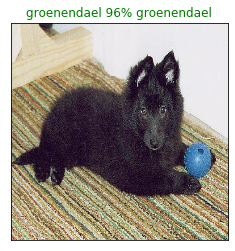

In [63]:
plot_pred(prediction_probabilities=predictions,
          labels=val_labels,
         images=val_images,
         n=77)


Now we've go one function to visualize our models top prediction, let's make another to view our models top 10 predictions

This function will :
   * Take an input of predictoin probabilities array and a ground truth array and an integer.
   * Find the prediction using `get_pred_label()`
   * Find the top 10 :
        * Prediction probabilities indexes
        * Prediction probabilities values
        * Prediction labels 
   * Plot the top 10 prediction probability values and labels, coloring the true label green

In [64]:
def plot_pred_conf(prediction_probabilities,labels,n=1):
    """
    Plot the top 10 highest prediction confidences along with the truth label for sample n.
    """
    
    pred_prob,true_label=prediction_probabilities[n],labels[n]
    
    # Get the predicted label
    pred_label=get_pred_label(pred_prob)
    
    # Find the top 10 prediction confidences indexes
    top_10_pred_indexes=pred_prob.argsort()[-10:][::-1]
    
    # Find the top 10 prediction confidence values
    top_10_pred_values=pred_prob[top_10_pred_indexes]
    
    # Find the top 10 prediction labels
    top_10_pred_labels=unique_breeds[top_10_pred_indexes]
    
    # Setup plot
    top_plot=plt.bar(np.arange(len(top_10_pred_labels)),
                    top_10_pred_values,
                    color="grey")
    plt.xticks(np.arange(len(top_10_pred_labels)),
              labels=top_10_pred_labels,
              rotation="vertical")
    
    # Change color of true label
    if np.isin(true_label,top_10_pred_labels):
        top_plot[np.argmax(top_10_pred_labels==true_label)].set_color("green")
        
    else:
        pass
    
    

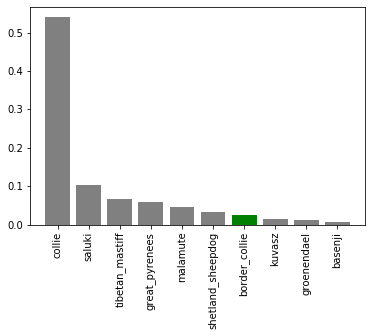

In [65]:
plot_pred_conf(prediction_probabilities=predictions,labels=val_labels,n=9)

Now we've got some function to help us visualize our predictions and evaluate our model, let's check out a few.

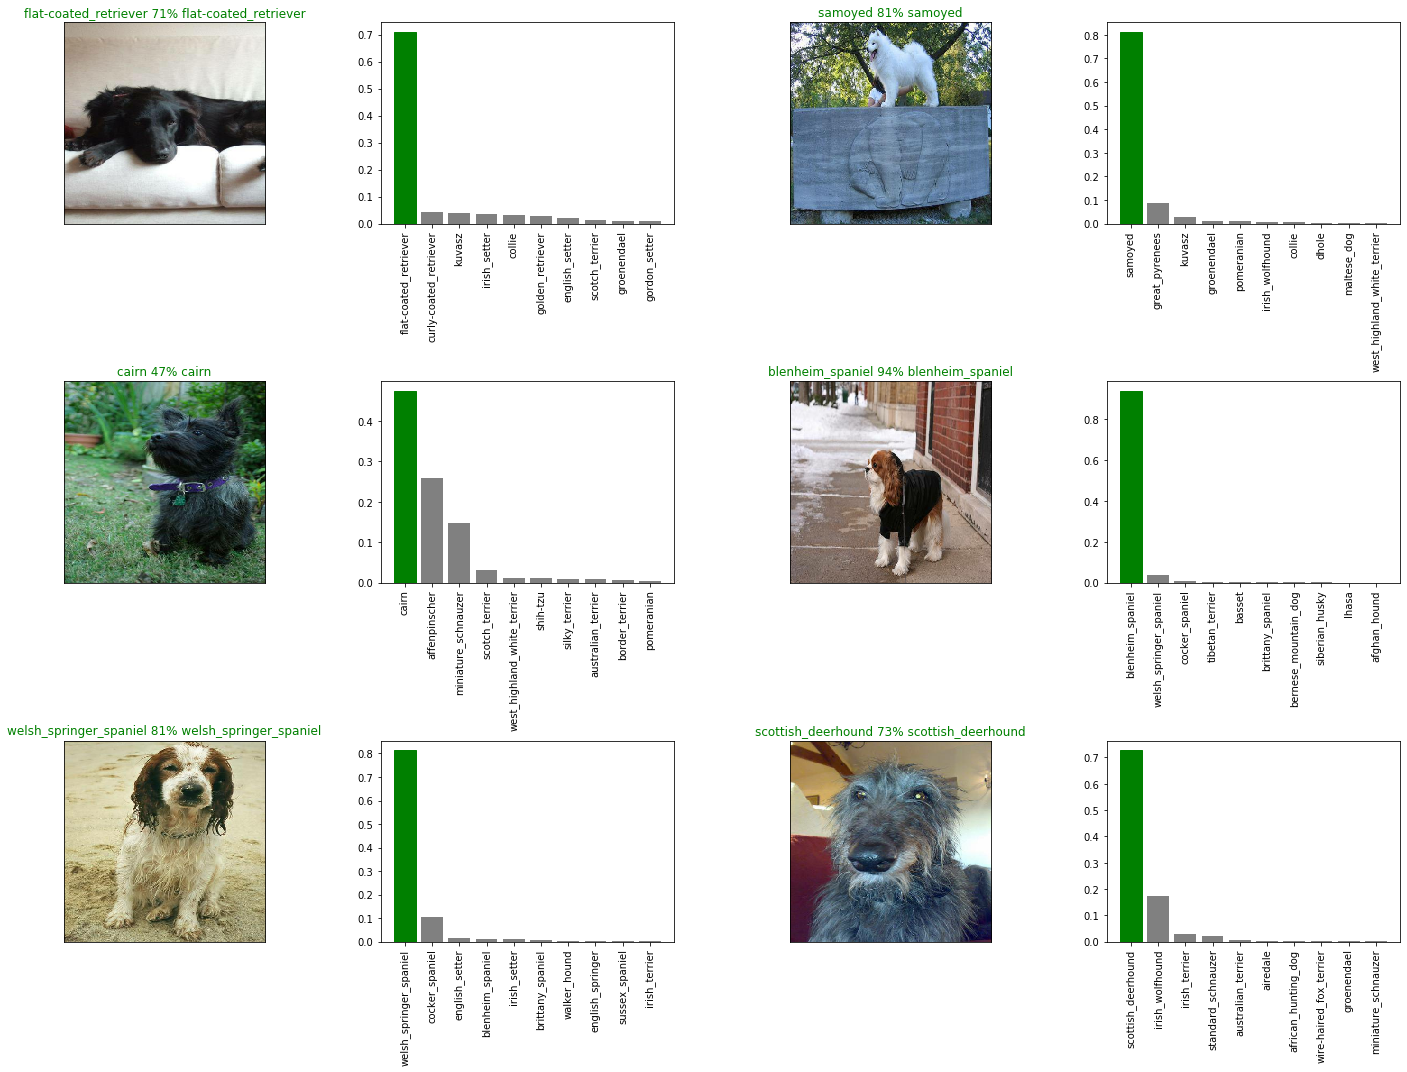

In [66]:
# Let's check out a few predictions and their different values
i_multiplier=20
num_rows=3
num_cols=2
num_images=num_rows*num_cols
plt.figure(figsize=(10*num_cols,5*num_rows))
for i in range(num_images):
    plt.subplot(num_rows,2*num_cols,2*i+1)
    plot_pred(prediction_probabilities=predictions,
             labels=val_labels,
              images=val_images,
             n=i+i_multiplier)
    plt.subplot(num_rows,2*num_cols,2*i+2)
    plot_pred_conf(prediction_probabilities=predictions,
                  labels=val_labels,
                  n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

In [67]:
from sklearn.metrics import confusion_matrix
predicted_labels=[]
for i in range(len(predictions)):
    predicted_labels.append(get_pred_label(predictions[i]))
conf_matrix=confusion_matrix(val_labels,predicted_labels)
conf_matrix

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 4, 0, ..., 0, 0, 0],
       [0, 0, 2, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 2, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]])

In [68]:
pd.DataFrame(conf_matrix)

0    1    2    3    4    5    6    7    8    9    ...  102  103  104  \
0      1    0    0    0    0    0    0    0    0    0  ...    0    0    0   
1      0    4    0    0    0    0    0    0    0    0  ...    0    0    0   
2      0    0    2    0    0    0    0    0    0    0  ...    0    0    0   
3      0    0    0    2    0    0    0    0    0    0  ...    1    0    0   
4      0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
107    0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
108    0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
109    0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
110    0    0    0    0    0    0    1    0    0    0  ...    0    0    0   
111    0    0    0    0    0    0    0    0    0    0  ...    0    0    0   

     105  106  107  108  109  110  111  
0      0    0    0    0    0    0    0  
1      0    0    0    0    0    0    0  
2      0    0    0    0    0    0    0  
3      0    0    0    0    0    0    0  
4      0    0    0    0    0    0    0  
..   ...  ...  ...  ...  ...  ...  ...  
107    0    0    3    0    0    0    0  
108    0    0    0    0    0    0    0  
109    0    0    0    0    2    0    0  
110    0    0    0    0    0    1    0  
111    0    0    0    0    0    0    1  

[112 rows x 112 columns]

## Saving and Reloading a trained model

In [53]:
# Create a function to save a model 
def save_model(model,suffix=None):
    """
    Saves a given model in a models directory and appends a suffix (string).
    """
    
    # Create a model directory pathname with current time
    modeldir=os.path.join("dog-breed-identification/models",
                         datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
    model_path=modeldir+"-"+suffix+".h5" # Save format of model
    print(f"Saving model to: {model_path}....")
    model.save(model_path)
    return model_path

In [27]:
# Create a function to load a trained model
def load_model(model_path):
    """
    Loads a saved model from a specific path.
    """
    print(f"Loading saved model from: {model_path}")
    model=tf.keras.models.load_model(model_path,
                                    custom_objects={"KerasLayer":hub.KerasLayer})
    return model


Now we've got functions to save and load a trained model ,let's make sure they work

In [102]:
# save our model trained on 1000 images
save_model(model,suffix="1000-images-mobilenetv2-Adam")

Saving model to: dog-breed-identification/models/20200621-13551592727903-1000-images-mobilenetv2-Adam.h5....


'dog-breed-identification/models/20200621-13551592727903-1000-images-mobilenetv2-Adam.h5'

In [71]:
# load a trained model 
loaded_1000_image_model=load_model('dog-breed-identification/models/20200621-13551592727903-1000-images-mobilenetv2-Adam.h5')

Loading saved model from: dog-breed-identification/models/20200621-13551592727903-1000-images-mobilenetv2-Adam.h5


In [69]:
# Evaluate the pre-saved model

model.evaluate(val_data)

13/13 [==============================] - 1s 109ms/step - loss: 5.5808 - accuracy: 0.0000e+00


[5.580787181854248, 0.0]

In [72]:
# Evaluate the loaded model
loaded_1000_image_model.evaluate(val_data)

13/13 [==============================] - 1s 110ms/step - loss: 1.1837 - accuracy: 0.7000


[1.1837462186813354, 0.699999988079071]

## Training a big dog model (on the full data)

In [73]:
len(X),len(Y)

(10222, 10222)

In [74]:
len(X_train)

800

In [75]:
# Create a data batch with the full dataset
full_data=create_data_batches(X,Y)

Creating training data batches....


In [76]:
full_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [77]:
# create a model for full_model
full_model=create_model()

Building model with: Downloads/imagenet_mobilenet_v2_130_224_classification_4


In [78]:
# Create full model callbacks
full_model_tensorboard=create =create_tensorboard_callback()

# No validation set when training on all the data, so we can't monitor validation accuracy
full_model_early_stopping=tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                          patience=3)

In [78]:
# Fit the full model to the full data
full_model.fit(x=full_data,
              epochs=NUM_EPOCHS,
              callbacks=[full_model_tensorboard,full_model_early_stopping])

Epoch 1/100
639/639 [==============================] - 90s 141ms/step - loss: 1.1980 - accuracy: 0.6915
Epoch 2/100
639/639 [==============================] - 80s 126ms/step - loss: 0.3624 - accuracy: 0.8925
Epoch 3/100
639/639 [==============================] - 81s 126ms/step - loss: 0.2033 - accuracy: 0.9405
Epoch 4/100
639/639 [==============================] - 81s 126ms/step - loss: 0.1263 - accuracy: 0.9662
Epoch 5/100
639/639 [==============================] - 80s 126ms/step - loss: 0.0828 - accuracy: 0.9797
Epoch 6/100
639/639 [==============================] - 80s 126ms/step - loss: 0.0613 - accuracy: 0.9853
Epoch 7/100
639/639 [==============================] - 81s 126ms/step - loss: 0.0475 - accuracy: 0.9899
Epoch 8/100
639/639 [==============================] - 81s 126ms/step - loss: 0.0357 - accuracy: 0.9937
Epoch 9/100
639/639 [==============================] - 81s 126ms/step - loss: 0.0304 - accuracy: 0.9948
Epoch 10/100
639/639 [==============================] - 80s 126m

In [79]:
save_model(full_model,suffix="full-image-set-mobilenetv2-Adam")

Saving model to: dog-breed-identification/models/20200621-17121592739746-full-image-set-mobilenetv2-Adam.h5....


'dog-breed-identification/models/20200621-17121592739746-full-image-set-mobilenetv2-Adam.h5'

In [28]:
# Load in the full model
loaded_full_model=load_model('dog-breed-identification/models/20200621-17121592739746-full-image-set-mobilenetv2-Adam.h5')

Loading saved model from: dog-breed-identification/models/20200621-17121592739746-full-image-set-mobilenetv2-Adam.h5


## Making Predictions on the test Dataset


Since our model has been trained on images in the form of Tensor batches,to make predictions on the test data, we'll have to get it into the same format.


Luckily we created `create_data_batches()` earlier which can take a list of filenames as input and convert them into Tensor batches.

To make predictions on the test data,we'll:

* Get the test image filenames.
* Convert the filenames into test data batches using `create_data_batches()` and setting the `test_data` parameter to `True` (since the test data doesn't have labels).
* Make a predictions array by passing the test batches to the `predict()` method called on our model.

In [29]:
# Load the test image filenames
import os
test_path="dog-breed-identification/test/"
test_filenames=[test_path+fname for fname in os.listdir(test_path)]
test_filenames[:10]

['dog-breed-identification/test/ad40b218aa7e1b1e927be03a6e2f84af.jpg',
 'dog-breed-identification/test/e29f03a924c493b29d17877204dd0205.jpg',
 'dog-breed-identification/test/ba7323fadf315946c6cfd74ead6826b2.jpg',
 'dog-breed-identification/test/dc110cfb9e242562f5ad75391594832d.jpg',
 'dog-breed-identification/test/2a984ccf9240459deaa90245b0bf9b59.jpg',
 'dog-breed-identification/test/06937730f6c9fbf37d2875c5f00940e3.jpg',
 'dog-breed-identification/test/aafeaab1de0124e7c213acd3473ca3c1.jpg',
 'dog-breed-identification/test/cc81257cec3438e30abb090b1ce7f441.jpg',
 'dog-breed-identification/test/378eebec90ad92fd22fe88eb2a875d17.jpg',
 'dog-breed-identification/test/0656848af0bcfa6437e08a084baa1a48.jpg']

In [57]:
len(test_filenames)

10357

In [58]:
# Create test data batch
test_data=create_data_batches(test_filenames,test_data=True)

Creating test data batches...


In [85]:
test_data

<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

In [86]:
# Make predictions on test data batch using the loaded full model
test_predictions=loaded_full_model.predict(test_data,
                                          verbose=1)

648/648 [==============================] - 86s 132ms/step


In [87]:
# Save predictions (Numpy array) to csv file (for access later)
np.savetxt("dog-breed-identification/preds_array.csv",test_predictions,delimiter=",")

In [59]:
test_predictions=np.loadtxt("dog-breed-identification/preds_array.csv",delimiter=",")

In [60]:
test_predictions[:10]

array([[4.90387619e-10, 4.58192168e-04, 2.81488333e-10, ...,
        1.34289312e-05, 3.32457853e-06, 1.62105749e-07],
       [1.01937232e-08, 3.07694398e-04, 1.24266231e-11, ...,
        5.27098168e-13, 3.89328036e-08, 1.15987497e-09],
       [1.69132687e-12, 5.65914164e-14, 5.52678258e-14, ...,
        2.57264126e-13, 2.60988939e-11, 4.53959439e-11],
       ...,
       [3.66301392e-04, 3.51893464e-15, 2.54133738e-07, ...,
        1.36396832e-08, 1.33094897e-13, 4.35737668e-09],
       [3.47088612e-12, 2.04630641e-08, 1.39313049e-11, ...,
        3.34117825e-13, 9.07182107e-10, 7.23147977e-08],
       [1.31736039e-13, 3.17150494e-13, 7.80711953e-12, ...,
        5.25716804e-02, 2.07770648e-10, 6.22848398e-13]])

In [61]:
test_predictions.shape


(10357, 120)

## Preparing test dataset predictions for Kaggle


Looking at the Kaggle sample submission, we find that it wants our models prediction probability outputs in a DataFrame with an ID and a column for each different dog breed.

To get the data in this format, we'll:
* Create a pandas DataFrame with an ID column as well as a column for each dog breed.
* Add data to the ID column by extracting the test image ID's from their filepaths.
* Add data (the prediction probabilities) to each of the dog breed columns.
* Export the DataFrame as a CSV to submit it to Kaggle.

In [62]:
# Create a Pandas Dataframe
preds_df=pd.DataFrame(columns=["id"]+list(unique_breeds))

In [63]:
preds_df.head()

Empty DataFrame
Columns: [id, affenpinscher, afghan_hound, african_hunting_dog, airedale, american_staffordshire_terrier, appenzeller, australian_terrier, basenji, basset, beagle, bedlington_terrier, bernese_mountain_dog, black-and-tan_coonhound, blenheim_spaniel, bloodhound, bluetick, border_collie, border_terrier, borzoi, boston_bull, bouvier_des_flandres, boxer, brabancon_griffon, briard, brittany_spaniel, bull_mastiff, cairn, cardigan, chesapeake_bay_retriever, chihuahua, chow, clumber, cocker_spaniel, collie, curly-coated_retriever, dandie_dinmont, dhole, dingo, doberman, english_foxhound, english_setter, english_springer, entlebucher, eskimo_dog, flat-coated_retriever, french_bulldog, german_shepherd, german_short-haired_pointer, giant_schnauzer, golden_retriever, gordon_setter, great_dane, great_pyrenees, greater_swiss_mountain_dog, groenendael, ibizan_hound, irish_setter, irish_terrier, irish_water_spaniel, irish_wolfhound, italian_greyhound, japanese_spaniel, keeshond, kelpie, kerry_blue_terrier, komondor, kuvasz, labrador_retriever, lakeland_terrier, leonberg, lhasa, malamute, malinois, maltese_dog, mexican_hairless, miniature_pinscher, miniature_poodle, miniature_schnauzer, newfoundland, norfolk_terrier, norwegian_elkhound, norwich_terrier, old_english_sheepdog, otterhound, papillon, pekinese, pembroke, pomeranian, pug, redbone, rhodesian_ridgeback, rottweiler, saint_bernard, saluki, samoyed, schipperke, scotch_terrier, scottish_deerhound, sealyham_terrier, ...]
Index: []

[0 rows x 121 columns]

In [68]:
# Append test image ID's to predictions DataFrame
test_ids=[os.path.splitext(path)[0] for path in os.listdir(test_path)]

In [69]:
preds_df["id"]=test_ids

In [70]:
preds_df.head()

id affenpinscher afghan_hound  \
0  ad40b218aa7e1b1e927be03a6e2f84af           NaN          NaN   
1  e29f03a924c493b29d17877204dd0205           NaN          NaN   
2  ba7323fadf315946c6cfd74ead6826b2           NaN          NaN   
3  dc110cfb9e242562f5ad75391594832d           NaN          NaN   
4  2a984ccf9240459deaa90245b0bf9b59           NaN          NaN   

  african_hunting_dog airedale american_staffordshire_terrier appenzeller  \
0                 NaN      NaN                            NaN         NaN   
1                 NaN      NaN                            NaN         NaN   
2                 NaN      NaN                            NaN         NaN   
3                 NaN      NaN                            NaN         NaN   
4                 NaN      NaN                            NaN         NaN   

  australian_terrier basenji basset  ... toy_poodle toy_terrier vizsla  \
0                NaN     NaN    NaN  ...        NaN         NaN    NaN   
1                NaN     NaN    NaN  ...        NaN         NaN    NaN   
2                NaN     NaN    NaN  ...        NaN         NaN    NaN   
3                NaN     NaN    NaN  ...        NaN         NaN    NaN   
4                NaN     NaN    NaN  ...        NaN         NaN    NaN   

  walker_hound weimaraner welsh_springer_spaniel west_highland_white_terrier  \
0          NaN        NaN                    NaN                         NaN   
1          NaN        NaN                    NaN                         NaN   
2          NaN        NaN                    NaN                         NaN   
3          NaN        NaN                    NaN                         NaN   
4          NaN        NaN                    NaN                         NaN   

  whippet wire-haired_fox_terrier yorkshire_terrier  
0     NaN                     NaN               NaN  
1     NaN                     NaN               NaN  
2     NaN                     NaN               NaN  
3     NaN                     NaN               NaN  
4     NaN                     NaN               NaN  

[5 rows x 121 columns]

In [71]:
# Add the prediction probabilities to each dog breed column
preds_df[list(unique_breeds)]=test_predictions
preds_df.head()

id affenpinscher afghan_hound  \
0  ad40b218aa7e1b1e927be03a6e2f84af   4.90388e-10  0.000458192   
1  e29f03a924c493b29d17877204dd0205   1.01937e-08  0.000307694   
2  ba7323fadf315946c6cfd74ead6826b2   1.69133e-12  5.65914e-14   
3  dc110cfb9e242562f5ad75391594832d   7.32343e-09  1.58729e-08   
4  2a984ccf9240459deaa90245b0bf9b59    7.9066e-10  1.22805e-10   

  african_hunting_dog     airedale american_staffordshire_terrier  \
0         2.81488e-10  8.57203e-07                    1.22052e-08   
1         1.24266e-11  5.64561e-15                    1.29444e-11   
2         5.52678e-14  3.75672e-14                    1.00885e-11   
3         1.48458e-09  0.000117535                    1.46253e-06   
4         3.29319e-12   2.6696e-11                    4.35031e-07   

   appenzeller australian_terrier      basenji       basset  ...   toy_poodle  \
0  1.50336e-11        2.19651e-08  1.11764e-11   2.8041e-13  ...  6.82168e-10   
1  4.23502e-16        1.50615e-13  2.59301e-14  1.97531e-13  ...  7.48016e-10   
2  1.74954e-11        4.41867e-10  2.67876e-09  3.54079e-11  ...  4.95346e-12   
3  9.09864e-10            0.76507  6.45619e-07  9.45562e-09  ...  2.85464e-10   
4  2.20049e-09        2.58119e-07  1.06072e-09  2.04202e-13  ...   8.2468e-06   

   toy_terrier       vizsla walker_hound   weimaraner welsh_springer_spaniel  \
0  2.23899e-11  2.62307e-10  0.000118957  4.70616e-10            6.34289e-06   
1  8.95346e-16  2.34499e-12   2.4041e-12  2.84361e-12            3.88169e-14   
2  2.37463e-10  9.00658e-11  4.08469e-07  4.54444e-12             8.1216e-12   
3  2.16787e-10  9.05686e-10  5.41628e-10  7.59523e-12            2.60808e-06   
4  4.37922e-11  5.78905e-09  4.61434e-10  1.50019e-07              4.455e-13   

  west_highland_white_terrier      whippet wire-haired_fox_terrier  \
0                 3.66132e-09  1.34289e-05             3.32458e-06   
1                   5.957e-11  5.27098e-13             3.89328e-08   
2                 5.77659e-12  2.57264e-13             2.60989e-11   
3                  3.1264e-09  1.01479e-09             3.51419e-09   
4                 5.66458e-11   4.9688e-12             7.86459e-11   

  yorkshire_terrier  
0       1.62106e-07  
1       1.15987e-09  
2       4.53959e-11  
3       4.20314e-07  
4       1.65843e-10  

[5 rows x 121 columns]

In [73]:
# Save our predictions DataFrame to csv for submission to kaggle
preds_df.to_csv("dog-breed-identification/full_model_predictions_submission_1_mobilenetV2.csv",index=False)

## Make predictions on custom images

To make predictions on custom images, we'll:

* Get the filepaths of our own images.
* Turn the filepaths into data batches using `create_data_batches()`. And since our custom images won't have labels, we set the `test_data` parameter to `True`.
* Pass the custom image data batch to our model's `predict()` method.
* Convert the predictions output probabilities to predictions labels.
* Compare the predicted labels to the custom images.

In [76]:
# Get custom image filepaths
custom_image_paths=["dog-photo.png","car-photo.png","panda.png"]

In [77]:
custom_image_paths

['dog-photo.png', 'car-photo.png', 'panda.png']

In [78]:
# Turn custom images into batch dataset
custom_data=create_data_batches(custom_image_paths,test_data=True)
custom_data

Creating test data batches...


<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

In [79]:
# Make predictions on the custom data 
custom_preds=loaded_full_model.predict(custom_data)

In [81]:
custom_preds.shape

(3, 120)

In [83]:
# Get custom image prediction labels
custom_pred_labels=[get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

['golden_retriever', 'norwich_terrier', 'giant_schnauzer']

In [84]:
# Get custom images (our unbatchify() function won't work since there aren't labels.... maybe we could fix this later)
custom_images=[]
# Loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
    custom_images.append(image)
    


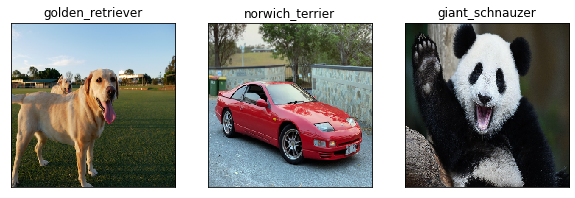

In [85]:
# Check Custom image predictions
plt.figure(figsize=(10,10))
for i,image in enumerate(custom_images):
    plt.subplot(1,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.title(custom_pred_labels[i])
    plt.imshow(image)